In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

def generate_random_signal(n_points=100, max_peaks=4, noise_std=0.02, fixed_width=0.3):
    """
    Generate a 1D signal of length n_points containing up to max_peaks Gaussians.
    We only vary amplitude and center; the width is fixed.
    """
    x = np.linspace(-5, 5, n_points)
    y = np.zeros_like(x)
    
    n_peaks = np.random.randint(1, max_peaks+1)
    for _ in range(n_peaks):
        amp = np.random.uniform(0.5, 2.0)
        cen = np.random.uniform(-4.0, 4.0)
        y += amp * np.exp(-0.5 * ((x - cen) / fixed_width)**2)
    
    # Add Gaussian noise
    y += np.random.normal(0.0, noise_std, size=n_points)
    return x.astype(np.float32), y.astype(np.float32)

# Create multiple signals
n_samples = 2000
n_points  = 100
fixed_width = 0.3  # Same width used in data generation and the model

X_data = []
for _ in range(n_samples):
    x_axis, y_signal = generate_random_signal(
        n_points=n_points, 
        max_peaks=4, 
        noise_std=0.03, 
        fixed_width=fixed_width
    )
    X_data.append(y_signal)
X_data = np.array(X_data, dtype=np.float32)  # shape (n_samples, n_points)

# Train/test split
split_idx = int(0.8 * n_samples)
X_train = X_data[:split_idx]  # (1600, 100)
X_test  = X_data[split_idx:]  # (400,  100)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# We'll reuse x_axis (same for all signals)
x_positions = x_axis  # shape (100,)


X_train shape: (1600, 100)
X_test shape : (400, 100)


In [43]:
class GaussianDecoder(layers.Layer):
    """
    Decodes (amp1..amp4, cen1..cen4) into a 1D signal of length n_points
    using a fixed width (e.g., 0.3).
    """
    def __init__(self, x_positions, fixed_width=0.3, num_peaks=4, **kwargs):
        super().__init__(**kwargs)
        self.x_positions = tf.constant(x_positions, dtype=tf.float32)  # shape (N,)
        self.fixed_width = fixed_width
        self.num_peaks   = num_peaks
        self.N           = x_positions.shape[0]  # length of the signal

    def call(self, inputs):
        """
        inputs shape: (batch_size, 2*num_peaks)
          - first num_peaks = amplitudes
          - second num_peaks = centers
        returns shape: (batch_size, N)
        """
        batch_size = tf.shape(inputs)[0]

        amps    = inputs[:, :self.num_peaks]               # (batch_size, 4)
        centers = inputs[:, self.num_peaks:2*self.num_peaks]  # (batch_size, 4)

        # Expand x_positions => (1, N), then tile => (batch_size, num_peaks, N)
        x_2d = tf.reshape(self.x_positions, (1, self.N))
        x_tiled = tf.tile(
            tf.expand_dims(x_2d, axis=1),  # => (1, 1, N)
            [batch_size, self.num_peaks, 1]  # => (batch_size, 4, N)
        )

        # Expand amps, centers => (batch_size, 4, 1)
        amps_3d    = tf.expand_dims(amps,    axis=-1)  # => (batch_size, 4, 1)
        centers_3d = tf.expand_dims(centers, axis=-1)  # => (batch_size, 4, 1)

        # Fixed width => scalar => broadcast to (batch_size, 4, N)
        width = self.fixed_width

        # Compute Gaussians => (batch_size, 4, N)
        gaussians = amps_3d * tf.exp(-0.5 * tf.square((x_tiled - centers_3d) / width))

        # Sum across the 4 peaks => (batch_size, N)
        output = tf.reduce_sum(gaussians, axis=1)
        return output


In [44]:
def build_positions_amplitudes_model(n_points=100, num_peaks=4, fixed_width=0.3):
    """
    Builds a model that:
      Input:  (batch_size, n_points)
      Output: (batch_size, n_points)
      Hidden representation: 8 parameters (4 amps + 4 centers)
    """
    inputs = layers.Input(shape=(n_points,), name="signal_input")

    # Encoder
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    
    # Output: 8 parameters => (amps, centers)
    param_output = layers.Dense(2 * num_peaks, activation='linear', name="param_output")(x)

    # Physics-based Decoder
    reconstructed_signal = GaussianDecoder(
        x_positions=x_positions,
        fixed_width=fixed_width,
        num_peaks=num_peaks,
        name="gaussian_decoder"
    )(param_output)

    # Build the model
    model = models.Model(inputs=inputs, outputs=reconstructed_signal, name="PeakFinderModel")
    return model

model = build_positions_amplitudes_model(
    n_points=n_points,
    num_peaks=4,
    fixed_width=fixed_width
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error'
)

model.summary()


Model: "PeakFinderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ signal_input (InputLayer)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ param_output (Dense)            │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_decoder                │ (None, 100)            │             0 │
│ (GaussianDecoder)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,144 (43.53 KB)

 Trainable params: 11,144 (43.53 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=150,
    batch_size=32,
    verbose=1
)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1832 - val_loss: 0.1607
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1581 - val_loss: 0.1485
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 0.1549 - val_loss: 0.1385
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.1399 - val_loss: 0.1331
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.1344 - val_loss: 0.1301
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 0.1233 - val_loss: 0.1173
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 0.1215 - val_loss: 0.1122
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.1144 - val_loss: 0.1113
Epoch 9/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 0.1087 - val_loss: 0.1059
Epoch 10/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.1036 - val_loss: 0.1025
Epoch 11/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 0.0982 - val_loss: 0.0931
Epoch 12/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 


Training completed.
Final training loss: 0.02118469402194023
Final validation loss: 0.03330394625663757
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


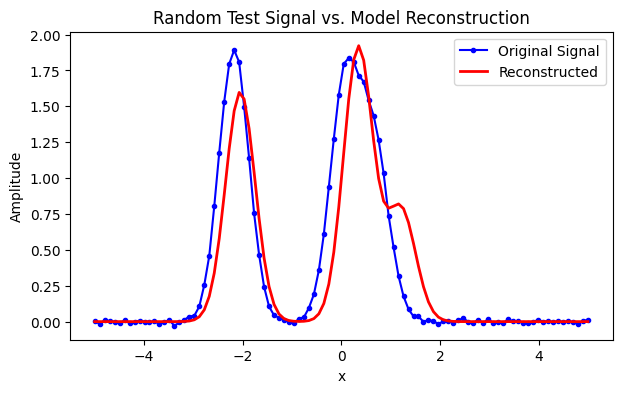

In [41]:
print("\nTraining completed.")
print("Final training loss:", history.history["loss"][-1])
print("Final validation loss:", history.history["val_loss"][-1])

# Pick a random test sample to see how well it reconstructs
idx = np.random.randint(0, X_test.shape[0])
test_signal = X_test[idx]               # shape (100,)
test_signal = test_signal[None, :]      # (1, 100)

reconstructed = model.predict(test_signal)[0]  # shape (100,)

# Plot
plt.figure(figsize=(7,4))
plt.plot(x_axis, test_signal[0], 'bo-', label='Original Signal', markersize=3)
plt.plot(x_axis, reconstructed, 'r-', label='Reconstructed', linewidth=2)
plt.title("Random Test Signal vs. Model Reconstruction")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
